In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Exploration of dataset 

In [479]:
df = pd.read_csv('/Users/michaelsigamani/Downloads/stack-overflow-2018-developer-survey/survey_results_public.csv', low_memory=False)
print(f'Shape Dataset:\t{df.shape}')

Shape Dataset:	(98855, 129)


This dataset has around 100k respondents with 129 questions. Lets only filter for the questions which we consider to be potentially relevant for task 2 (since data manipulation will be long and ardous if we consider all ~130 column headings). I have ignored almost all the rows from 19 (AssessJob1) until the end, since I don't assume these Likert Scale type questions to have any bearing on the number of years coding experience.  

In [480]:
df = df[['Country',
         'Employment',
         'CompanySize',
         'DevType',
         'YearsCoding',
         'YearsCodingProf',
         'ConvertedSalary',
         'Gender',
         'Dependents',
         'Student',
         'FormalEducation',
         'UndergradMajor',
         'Age']]

Lets look at the breakdown of the types of jobs surveyed to see if we can learn anything interesting.  

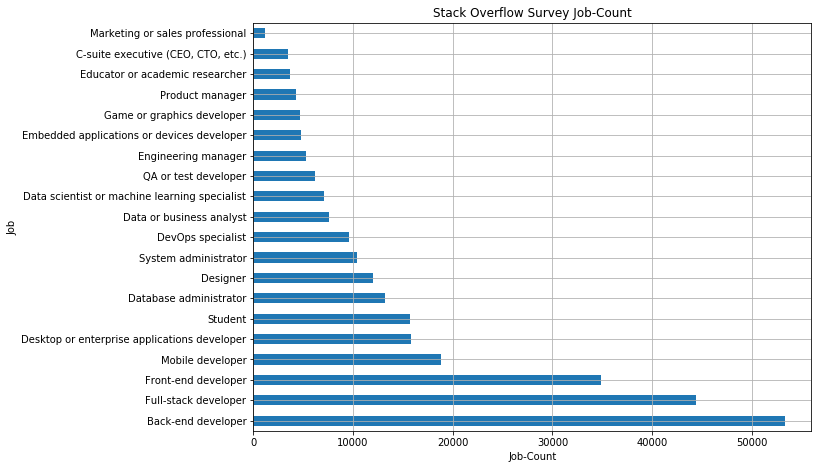

In [481]:
# Split the jobs and count them
df_jobs = pd.DataFrame.from_records(df['DevType'].dropna().apply(lambda x: x.split(';')).values.tolist()).stack().reset_index(drop=True).value_counts()

# Create plot
df_jobs.plot(kind='barh', figsize=(10,7.5))
plt.title('Stack Overflow Survey Job-Count')
plt.xlabel('Job-Count')
plt.ylabel('Job')
plt.grid()
plt.show()

I will make the hypothesis that developers, machine learning specialist, or DevOps will have a YearsCoding distribution skewed to higher numbers. I make this assumption since these are roles which tend to require coding, whereas management type roles don't always require this.   

In [482]:
# Make two dataframes one for developers and one for management

# Drop empty values
df = df.dropna(subset=['DevType'])

# Create dfs
df_dev = df[df['DevType'].str.contains('developer|DevOps|machine learning|Database|Engineering|researcher')] 
df = df[~df.isin(df_dev)].dropna()

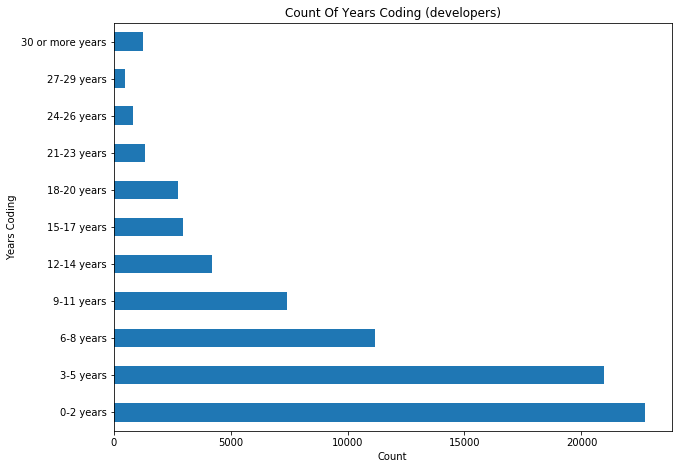

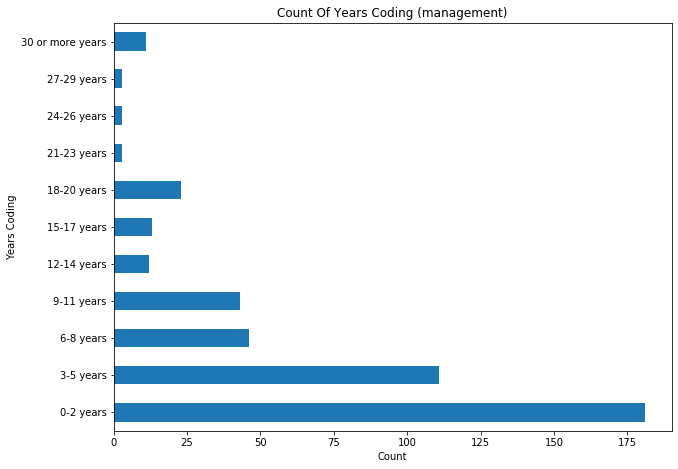

In [483]:
"""Transform years coding from a categorical 
string into an ordered numberical feature since 
we will train on this we want to preserve the order"""
years_coding = ['0-2 years', '3-5 years', '6-8 years', '9-11 years', '12-14 years', '15-17 years', '18-20 years', '21-23 years', '24-26 years', '27-29 years', '30 or more years']

# Create plots
df_dev['YearsCodingProf'].value_counts().reindex(years_coding).plot(kind='barh', figsize=(10,7.5))
plt.title('Count Of Years Coding (developers)')

plt.xlabel('Count')
plt.ylabel('Years Coding')
plt.show()

df['YearsCodingProf'].value_counts().reindex(years_coding).plot(kind='barh', figsize=(10,7.5))
plt.title('Count Of Years Coding (management)')
plt.xlabel('Count')
plt.ylabel('Years Coding')
plt.show()

I use the YearsCodingProf variable to study the effect rather than YearsCoding since "the number of years coding professionally" is less ambigious of a question. From the above two plots you can see a difference in the relative scales especially at the low end (as expected). Not as much as you go above the 3-5 year bin. 

NB. In fact if you change the variable to YearsCoding in both plots you can see less of a difference

In [484]:
# Add new binary variable for management and developer instead of DevType
df = df.drop('DevType', axis=1)
df['DevType'] = 0
df_dev = df_dev.drop('DevType', axis=1)
df_dev['DevType'] = 1

df2 = pd.concat([df, df_dev], axis=0)
print(f'Shape Dataset:\t{df2.shape}')

Shape Dataset:	(87295, 13)


Let's have a look at the salaries 

Empty Values:	0


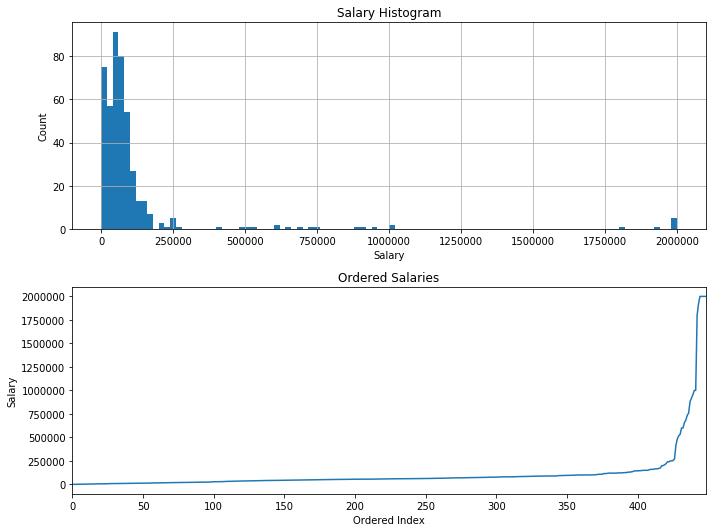

In [485]:
# Empty values
print('Empty Values:\t{}'.format(df['YearsCoding'].isna().sum()))

# Create subplots
fig, axarr = plt.subplots(2, figsize=(10,7.5))

# Create histogram
df['ConvertedSalary'].hist(bins=100, ax=axarr[0])
axarr[0].set_title('Salary Histogram')
axarr[0].set_xlabel('Salary')
axarr[0].set_ylabel('Count')

# Create sorted plot
df['ConvertedSalary'].sort_values().reset_index(drop=True).plot(ax=axarr[1])
axarr[1].set_title('Ordered Salaries')
axarr[1].set_xlabel('Ordered Index')
axarr[1].set_ylabel('Salary')


plt.tight_layout()
plt.show()

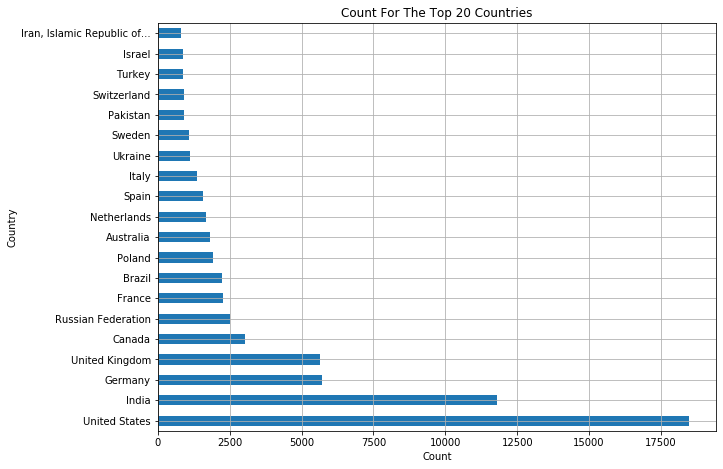

In [486]:
"""Check the breakdown of the home 
country of the respondents. Limit to the top 20"""
n = 20

# Create plot
df_country = df2['Country'].value_counts().head(n)
df_country.plot(kind='barh', figsize=(10,7.5))
plt.title('Count For The Top {} Countries'.format(n))
plt.xlabel('Count')
plt.ylabel('Country')
plt.grid()
plt.show()

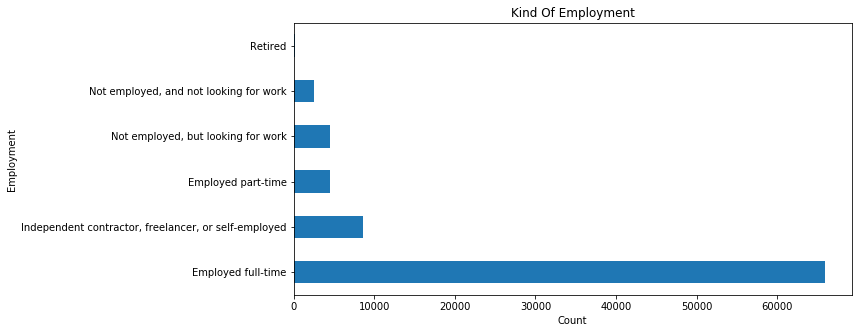

Shape Dataset:	(87295, 13)


In [487]:
# Look at employment type
df2['Employment'].value_counts().plot(kind='barh', figsize=(10,5))
plt.title('Kind Of Employment')
plt.xlabel('Count')
plt.ylabel('Employment')
plt.show()

print(f'Shape Dataset:\t{df2.shape}')

Independent contractor, freelancer, or self-employed employment types seem to be removed with our previous selections

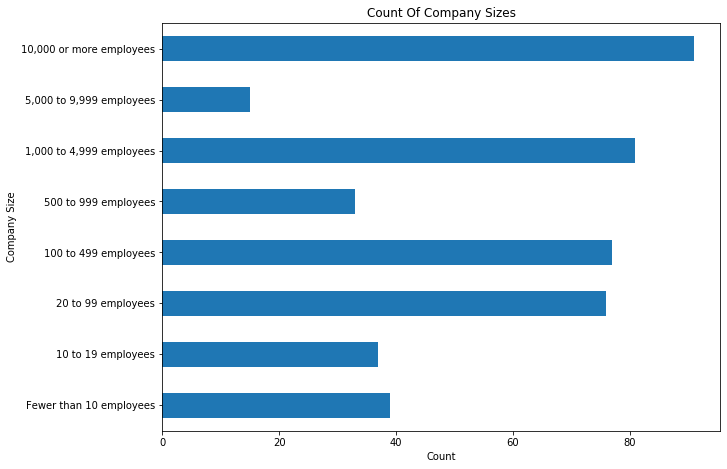

In [488]:
# Ordered company size
company_size = ['Fewer than 10 employees', '10 to 19 employees', '20 to 99 employees', '100 to 499 employees', '500 to 999 employees', '1,000 to 4,999 employees', '5,000 to 9,999 employees', '10,000 or more employees']

# Create plot
df['CompanySize'].value_counts().reindex(company_size).plot(kind='barh', figsize=(10,7.5))
plt.title('Count Of Company Sizes')
plt.xlabel('Count')
plt.ylabel('Company Size')
plt.show()

There's less than a few hundred filled values for this variable so I will not consider it for the classifier.

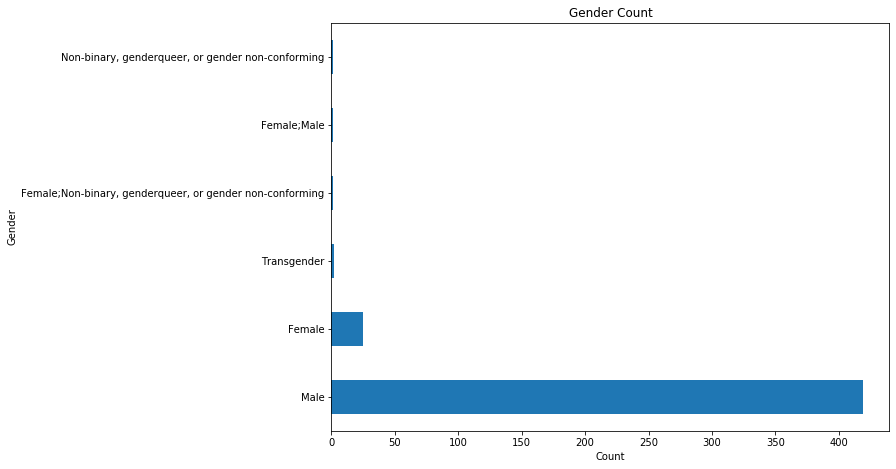

In [489]:
# Create plot
df['Gender'].value_counts().plot(kind='barh', figsize=(10,7.5))
plt.title('Gender Count')
plt.xlabel('Count')
plt.ylabel('Gender')
plt.show()

The breakdown of respondees is predominantly male, which is expected. So I will not consider this in the classifier either.

In [490]:
# Create mapping for years coding
mapping_years_coding = {key:i for i, key in enumerate(years_coding)}

# Drop empty values
df2 = df2.dropna(subset=['YearsCoding'])
df2 = df2.dropna(subset=['YearsCodingProf'])

# Transform category to numerical column
df2['YearsCoding'] = df2['YearsCoding'].map(mapping_years_coding)
df2['YearsCodingProf'] = df2['YearsCodingProf'].map(mapping_years_coding)

print(f'Shape Dataset:\t{df2.shape}')

Shape Dataset:	(76545, 13)


In [491]:
# Create mapping for years coding
df2['Dependents'] = df2['Dependents'].map({'No':0, 'Yes':1})
df2 = df2.dropna(subset=['Dependents'])

print(f'Shape Dataset:\t{df2.shape}')

Shape Dataset:	(58031, 13)


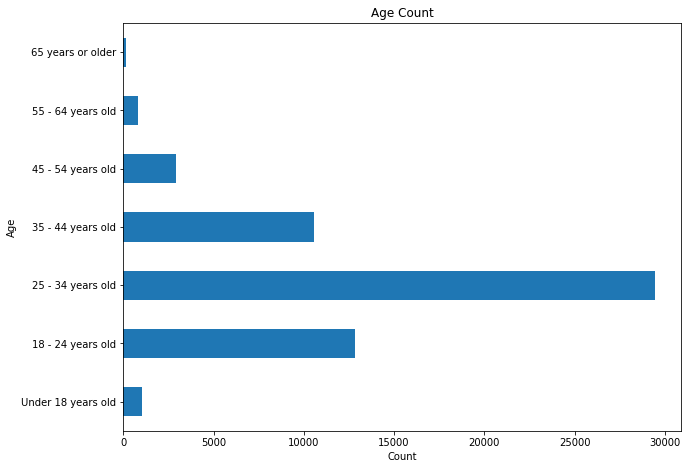

Shape Dataset:	(57758, 13)


In [492]:
# Ordered age sacle
age = ['Under 18 years old',
       '18 - 24 years old',
       '25 - 34 years old',
       '35 - 44 years old',
       '45 - 54 years old',
       '55 - 64 years old',
       '65 years or older']

# Empty values
df2 = df2.dropna(subset=['Age'])

# Create plot
df2['Age'].value_counts().reindex(age).plot(kind='barh', figsize=(10,7.5))
plt.title('Age Count')
plt.xlabel('Count')
plt.ylabel('Age')
plt.show()

print(f'Shape Dataset:\t{df2.shape}')

In [493]:
# Create mapping for years coding
mapping_age = {key:i for i, key in enumerate(age)}

# Transform category to numerical column
df2['Age'] = df2['Age'].map(mapping_age)

print(f'Shape Dataset:\t{df2.shape}')

Shape Dataset:	(57758, 13)


In [494]:
# Check correlations to see which variables are potentially useful. 
# Or intercorrlations between other variables
df2.corr()

,YearsCoding,YearsCodingProf,ConvertedSalary,Dependents,Age,DevType
YearsCoding,1.000000,0.869522,0.130877,0.335914,0.717078,0.007635
YearsCodingProf,0.869522,1.000000,0.144409,0.382482,0.772750,0.013537
ConvertedSalary,0.130877,0.144409,1.000000,0.052116,0.135853,-0.008992
Dependents,0.335914,0.382482,0.052116,1.000000,0.391264,-0.009494
Age,0.717078,0.772750,0.135853,0.391264,1.000000,-0.016484
DevType,0.007635,0.013537,-0.008992,-0.009494,-0.016484,1.000000


The main variables which are correlated to our target variable for Section 2 (YearsCodingProf) are Age, and YearsCoding as one would imagine. The older you are the more likely you are to have been developing longer. Also the amount of time you've been coding is expected to correlate highly to the amount of time you have coded professionally. The rest of the variables in the table are not correlated at all. I added the number of dependents since that would correlate slightly to age so might help the classifier. The rest are not useful.

In [495]:
df2 = df2[['YearsCoding',
           'YearsCodingProf',
           'Dependents',
           'Age']]

#bins = [-1, 2, 6, 9,10]
#labels =[0,1,2,3]
#df2['YearsCodingProf'] = pd.cut(df2['YearsCodingProf'], bins,labels=labels)

# Make a 90% / 10% train-test split.
train = df2.sample(frac=0.80, random_state=0)
test = df2.drop(train.index)

# Balance test set so our class sizes are equal
#test_b = test.groupby('YearsCodingProf')
#test_b = pd.DataFrame(test_b.apply(lambda x: x.sample(test_b.size().min()).reset_index(drop=True)))

train.to_csv("/Users/michaelsigamani/train.csv",index=False)
test.to_csv("/Users/michaelsigamani/test.csv",index=False)

In [496]:
print(f'Shape train:\t{train.shape}')
print(f'Shape test:\t{test.shape}')

Shape train:	(46206, 4)
Shape test:	(11552, 4)


In [497]:
train['YearsCodingProf'].value_counts().sort_index()

0     12583
1     12602
2      7005
3      4801
4      2799
5      1948
6      1860
7       892
8       552
9       331
10      833
Name: YearsCodingProf, dtype: int64

# Principle Components Analysis for segmentation

In [498]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df2)
pca.explained_variance_ratio_

array([0.90066415, 0.06122947])

90% of the variance of the data can be explained from the first principle component. 

In [499]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df2[['YearsCodingProf']]], axis = 1)

finalDf = finalDf.dropna(subset=['principal component 1'])
finalDf = finalDf.dropna(subset=['principal component 2'])
finalDf = finalDf.dropna(subset=['YearsCodingProf'])

print(f'Shape train:\t{finalDf.shape}')

Shape train:	(37603, 3)


In [500]:
finalDf.sample(3)

,principal component 1,principal component 2,YearsCodingProf
20675,6.132745,1.037003,0.0
36937,2.820204,-1.045839,2.0
55068,-3.201665,-0.162119,6.0


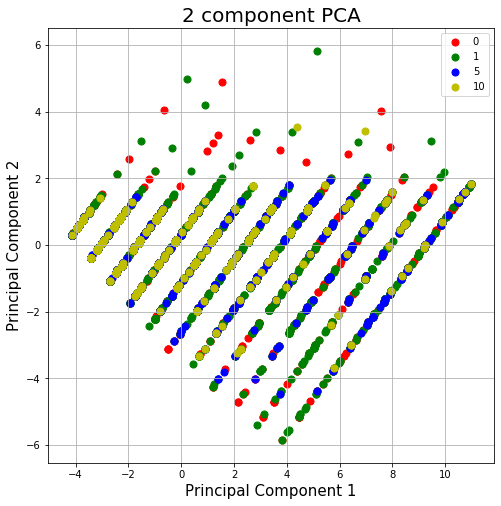

In [502]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 5, 10]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['YearsCodingProf'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Cant see any clusters from this